# Lecture 6 - Student Notebook

ASSISTments is a free tool for assigning and assessing math problems and homework. Teachers can select and assign problem sets. Once they get an assignment, students can complete it at their own pace and with the help of hints, multiple chances, and immediate feedback. Teachers get instant results broken down by individual student or for the whole class. The dataset involves 4,217 middle-school students practicing an electronic tutor that teaches and evaluates students in grade-school math, with a total of 525,534 trials. The student data are in a comma-delimited text file with one row per trial. The columns should correspond to a trial's user id, the order id (timestamp), the skill name, and and whether the student produced a correct response in the trial. More information on the platform can be found [here](https://www.commonsense.org/education/website/assistments). 

The ASSISTments data sets are often used for benchmarking knowledge tracing models. We will play with a simplified data set that contains the following columns:

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| user_id | The ID of the student who is solving the problem.  | |
| order_id | The temporal ID (timestamp) associated with the student's answer to the problem.  | |
| skill_name | The name of the skill associated with the problem. | |
| correct | The student's performance on the problem: 1 if the problem's answer is correct at the first attempt, 0 otherwise. 

We first load the data set.

In [1]:
# Principal package imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, roc_auc_score

# PyBKT package imports
from pyBKT.models import Model

DATA_DIR = "./../../data/"

In [2]:
assistments = pd.read_csv(DATA_DIR + 'assistments.csv', low_memory=False).dropna()
assistments.head()

,user_id,order_id,skill_name,correct
0,64525,33022537,Box and Whisker,1
1,64525,33022709,Box and Whisker,1
2,70363,35450204,Box and Whisker,0
3,70363,35450295,Box and Whisker,1
4,70363,35450311,Box and Whisker,0


Next, we print the number of unique students and skills in this data set.

In [3]:
print("Number of unique students in the dataset:", len(set(assistments['user_id'])))
print("Number of unique skills in the dataset:", len(set(assistments['skill_name'])))

Number of unique students in the dataset: 4151
Number of unique skills in the dataset: 110


To keep things simpler for demonstration purposes, we will focus on the following 6 skills in this lecture:  
`'Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle'`

In [4]:
skills_subset = ['Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle']
data = assistments[assistments['skill_name'].isin(skills_subset)]

print("Skill set:", set(data['skill_name']))
print("Number of unique students in the subset:", len(set(data['user_id'])))
print("Number of unique skills in the subset:", len(set(data['skill_name'])))

Skill set: {'Area Rectangle', 'Venn Diagram', 'Finding Percents', 'Circle Graph', 'Division Fractions', 'Mode'}
Number of unique students in the subset: 1527
Number of unique skills in the subset: 6


## BKT Models - Training & Prediction

We will use a train-test setting (20% of students in the test set). The `create_iterator` function creates an iterator object able to split student's interactions included in data in 10 folds such that the same student does not appear in two different folds. To do so, we appropriately initialize a scikit-learn's GroupShuffleSplit iterator with 80% training set size and non-overlapping groups, then return the iterator.

In [5]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupShuffleSplit(n_splits=1, train_size=.8, test_size=0.2, random_state=0).split(X, groups=groups)

Next, we train a BKT model for each skill on the training data set and then predict on the test data set.
We obtain `df_preds`, a data frame containing the predictions for each user and skill in the test data set. We output the overall RMSE and AUC scores.

In [6]:
rmse_bkt, auc_bkt = [], []
df_preds = pd.DataFrame()
# Train a BKT model for each skill
for skill in skills_subset:
    print("--", skill, "--")
    skill_data = data[data['skill_name'] == skill]
    for iteration, (train_index, test_index) in enumerate(create_iterator(skill_data)):
        # Split data in training and test sets
        X_train, X_test = skill_data.iloc[train_index], skill_data.iloc[test_index]
        # Initialize and fit the model
        model = Model(seed=0)
        %time model.fit(data=X_train) 
        # Compute predictions
        preds = model.predict(data=X_test)[['user_id', 'skill_name', 'correct', 'correct_predictions']]
        df_preds = df_preds.append(preds)
        
# Print the the resulting dataframe
display(df_preds)

# Compute overall RMSE and AUC
rmse = mean_squared_error(df_preds.correct, df_preds.correct_predictions, squared = False)
AUC = roc_auc_score(df_preds.correct, df_preds.correct_predictions)
print('RMSE:', rmse, 'AUC:', AUC)

-- Circle Graph --
CPU times: user 3.21 s, sys: 43.8 ms, total: 3.26 s
Wall time: 3.5 s


/tmp/ipykernel_476/755768163.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_preds = df_preds.append(preds)


-- Venn Diagram --
CPU times: user 3.85 s, sys: 27.1 ms, total: 3.87 s
Wall time: 3.99 s


/tmp/ipykernel_476/755768163.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_preds = df_preds.append(preds)


-- Mode --
CPU times: user 1.65 s, sys: 12.6 ms, total: 1.66 s
Wall time: 1.79 s


/tmp/ipykernel_476/755768163.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_preds = df_preds.append(preds)


-- Division Fractions --
CPU times: user 5.65 s, sys: 64.5 ms, total: 5.72 s
Wall time: 5.89 s


/tmp/ipykernel_476/755768163.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_preds = df_preds.append(preds)


-- Finding Percents --
CPU times: user 3.75 s, sys: 19.7 ms, total: 3.77 s
Wall time: 3.89 s


/tmp/ipykernel_476/755768163.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_preds = df_preds.append(preds)


-- Area Rectangle --
CPU times: user 2.23 s, sys: 27 ms, total: 2.26 s
Wall time: 2.3 s


/tmp/ipykernel_476/755768163.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_preds = df_preds.append(preds)


,user_id,skill_name,correct,correct_predictions
3969,64525,Circle Graph,1,0.46370
3970,64525,Circle Graph,1,0.63942
3971,64525,Circle Graph,1,0.69463
3972,64525,Circle Graph,0,0.70622
3973,64525,Circle Graph,1,0.70147
...,...,...,...,...
337153,96264,Area Rectangle,1,0.89253
337154,96264,Area Rectangle,1,0.97978
337159,96270,Area Rectangle,1,0.89253
337167,96292,Area Rectangle,1,0.89253


RMSE: 0.3559377380476281 AUC: 0.8666794592406339


## Your Turn - Training & Prediction

Next, we assume that the RMSE and AUC might differ depending on the skill. Your task is to:
1. Compute one of the metrics (RMSE or AUC) separately for each skill. 
2. Compute the mean of the selected metric (+ standard deviation) over all skills.
3. Create a visualization that displays: the mean of the metric (+ standard deviation) over all skills *and* the metric per skill.
4. Discuss your findings.

In [7]:
import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

npt_config = {
    'session_name': 'lecture-06',
    'session_owner': 'mlbd',
    'sender_name': input("Your name: "),
}

Your name:  Olivia


In [ ]:
# More efficient to do groupy(skill).apply(lambda x: mean_squared_error(x[],x[]))

In [14]:
rmses = {}
for skill in skills_subset:
    rmse = mean_squared_error(df_preds.query(f'skill_name == "{skill}"').correct, df_preds.query(f'skill_name == "{skill}"').correct_predictions, squared = False)
    rmses[skill] = rmse

rmses

{'Circle Graph': 0.4543182058730104,
 'Venn Diagram': 0.32397733706720083,
 'Mode': 0.3600622897737491,
 'Division Fractions': 0.4230121265888165,
 'Finding Percents': 0.4372976552705902,
 'Area Rectangle': 0.2507614888867876}

In [36]:
aucs = {}
for skill in skills_subset:
    auc = roc_auc_score(df_preds.query(f'skill_name == "{skill}"').correct, df_preds.query(f'skill_name == "{skill}"').correct_predictions)
    aucs[skill] = auc

aucs

{'Circle Graph': 0.7345060394908528,
 'Venn Diagram': 0.9113133419350231,
 'Mode': 0.7902208201892745,
 'Division Fractions': 0.7645182972367437,
 'Finding Percents': 0.784878784183747,
 'Area Rectangle': 0.7506945950032885}

In [25]:
rmses.values()

dict_values([0.4543182058730104, 0.32397733706720083, 0.3600622897737491, 0.4230121265888165, 0.4372976552705902, 0.2507614888867876])

In [30]:
np.std(list(rmses.values()))

0.07157646328393136

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

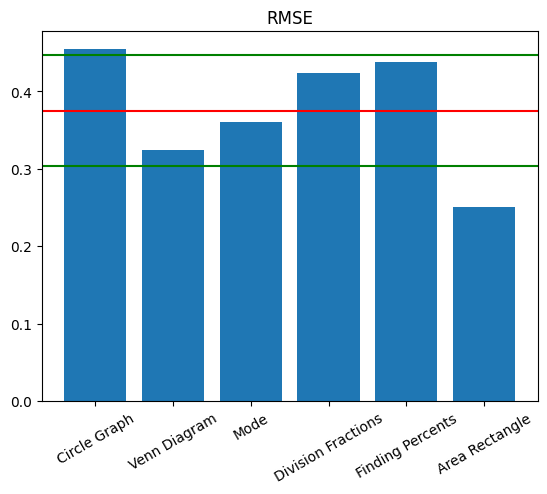

In [32]:
plt.bar(rmses.keys(),rmses.values())
plt.axhline(y=np.mean(list(rmses.values())),color='red')
plt.axhline(y=np.mean(list(rmses.values())+np.std(list(rmses.values()))),color='green')
plt.axhline(y=np.mean(list(rmses.values())- np.std(list(rmses.values()))),color='green')
plt.title("RMSE")
plt.xticks(rotation=30)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

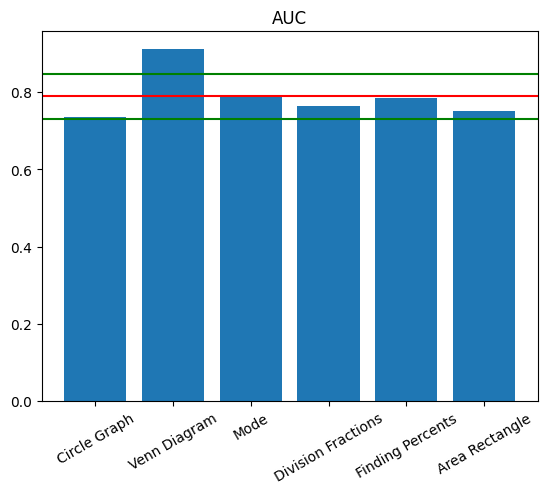

In [37]:
plt.bar(aucs.keys(),aucs.values())
plt.axhline(y=np.mean(list(aucs.values())),color='red')
plt.axhline(y=np.mean(list(aucs.values())+np.std(list(aucs.values()))),color='green')
plt.axhline(y=np.mean(list(aucs.values())- np.std(list(aucs.values()))),color='green')
plt.title("AUC")
plt.xticks(rotation=30)

<string>:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6


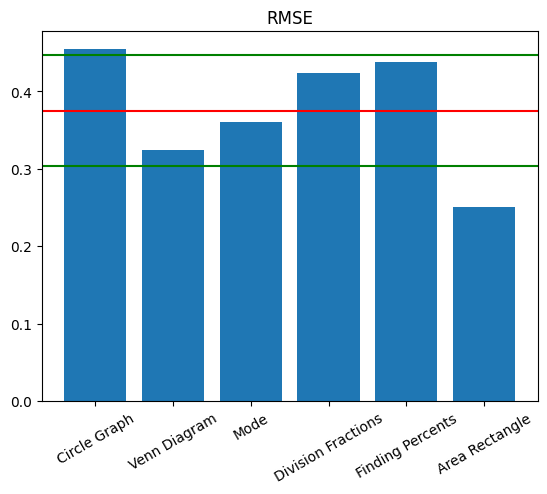

In [34]:
# YOUR TURN: Your code for computing the metrics goes here

### Share your metric visualization plot with us
plt.bar(rmses.keys(),rmses.values())
plt.axhline(y=np.mean(list(rmses.values())),color='red')
plt.axhline(y=np.mean(list(rmses.values())+np.std(list(rmses.values()))),color='green')
plt.axhline(y=np.mean(list(rmses.values())- np.std(list(rmses.values()))),color='green')
plt.title("RMSE")
plt.xticks(rotation=30)
send(plt, 1)
plt.show()


In [ ]:

### Share your analysis of the metric 
metric_discussion = "Some skills might be easier to predict since all student get the right, for example"
send(metric_discussion, 2)